In [1]:
DATA_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/data2/' # "./../"
DATA_VERSION = 'oct22'
RESULTS_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/results/'
SHAM = True

########################################################################################
sham_str = '_wSham' if SHAM else ''

In [2]:
import os 
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import anndata as ann
from scipy.sparse import issparse

from scipy.sparse import csr_matrix
from matplotlib import rcParams
from matplotlib import colors

import datetime

#plt.rcParams['figure.dpi'] = 300

#sc.logging.print_versions()

In [3]:
region_to_color = {
    "Calvaria"  : "#e377c2",
    "Brain"     : "#1f77b4",
    "Femur"     : "#ff7f0e",
    "Humerus"   : "#279e68",
    "Meninges"  : "#d62728",
    "Pelvis"    : "#aa40fc",
    "Scapula"   : "#8c564b",
    "Vertebra"  : "#b5bd61",
}

condition_to_color = {
    'MCAo'      : "#1f77b4",
    'Naive'     : "#ff7f0e",
    'Sham'      : "#279e68",
}

# Check list of DAMP markers (including pooled score)

In [4]:
adata = sc.read(DATA_DIR+f'cellxgene_{DATA_VERSION}{sham_str}_umaps.h5ad')

adata.obs['region'] = adata.obs['region'].cat.rename_categories({'Skull': 'Calvaria'})
adata.obs['condition'] = adata.obs['condition'].cat.rename_categories({'MCAO': 'MCAo'})
adata.obs['region_condition'] = adata.obs["region"].astype(str) + "_" + adata.obs["condition"].astype(str)
adata.obs['injury'] = adata.obs['condition'].astype(str)
adata.obs.loc[adata.obs['injury'].isin(["Sham","MCAo"]),'injury'] = "Injury"

In [5]:
damps = [
    "TLR2", "TLR3", "TLR4", "TLR7", "TLR9", "DNGR1", "MINCLE", "Dectin-1", "NLRP3", "RIG-I", "MDA5", 
    "cGAS", "AIM2", "RAGE", "TREM1", "TREM2", "FPR1", "FPR2", "P2Y2R", "P2Y6R", "P2Y12R", "CaSR", 
    "GPRC6A", "TRPM2", "P2X7R"
]

damps = [d[0].upper() + d[1:].lower() for d in damps]
damps = [d for d in damps if d in adata.var_names]

In [6]:
bones_no_scapula = ['Femur', 'Humerus', 'Pelvis', 'Calvaria', 'Vertebra']

CD45_cts = [
    'progenitors',
    'neutrophil',
    'monocyte',
    'B cell',
    'T cell',
    'NK cell',
    'NK-T cell',
    'dendritic cell',
    'macrophage',
    'microglia',
    #'erythroid precursor',
    #'erythroid cell',
    'basophil',
    #'structural cell',
    #'brain cell',
    'megakaryocyte',
    'innate lymphoid cell',
]

adata = adata[adata.obs["region"].isin(bones_no_scapula) & adata.obs["level1"].isin(CD45_cts),damps]

In [48]:
dfs = {}
for cond in ["Naive","Sham","MCAo"]:
    
    print(f"#### {cond} ####")
    
    a_cond = adata[adata.obs["condition"] == cond].copy()
    
    sc.tl.rank_genes_groups(a_cond,"region")
    tmp = sc.get.rank_genes_groups_df(a_cond,"Calvaria")
    tmp["Calvaria up/down"] = "down"
    tmp.loc[tmp["scores"] > 0,"Calvaria up/down"] = "up"
    tmp["significant"] = tmp["pvals_adj"] < 0.05
    
    a = ann.AnnData(
        X = a_cond.X.toarray().mean(axis=1)[:,np.newaxis],
        obs = a_cond.obs,
        var = pd.DataFrame(index=["DAMPS_pooled"])
    )    
    
    sc.tl.rank_genes_groups(a,"region")
    tmp2 = sc.get.rank_genes_groups_df(a,"Calvaria")
    tmp2["Calvaria up/down"] = "down"
    tmp2.loc[tmp2["scores"] > 0,"Calvaria up/down"] = "up"
    tmp2["significant"] = tmp2["pvals_adj"] < 0.05
    
    tmp = pd.concat([tmp,tmp2])
    
    display(tmp[["names","logfoldchanges","Calvaria up/down","pvals_adj","significant"]])
    
    dfs[cond] = tmp[["names","logfoldchanges","Calvaria up/down","pvals_adj","significant"]]
    
from pandas import ExcelWriter

with ExcelWriter("./DAMPS_tests_per_condition.xlsx") as writer:
    for sheet, df in dfs.items():
        df.to_excel(writer,sheet)

#### Naive ####


/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


,names,logfoldchanges,Calvaria up/down,pvals_adj,significant
0,Trem1,1.814169,up,3.093670e-109,True
1,Tlr2,0.750101,up,9.431261e-25,True
2,Nlrp3,0.815611,up,8.457379e-24,True
3,Trpm2,0.402514,up,7.309857e-13,True
4,Fpr1,0.212237,up,3.418038e-04,True
5,Fpr2,0.067588,up,2.446226e-01,False
6,Tlr4,0.065110,up,6.901915e-01,False
7,Tlr9,0.275029,up,6.901915e-01,False
8,Aim2,-0.001743,down,9.827746e-01,False
9,Tlr3,-0.246932,down,7.822355e-01,False


#### Sham ####


/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


,names,logfoldchanges,Calvaria up/down,pvals_adj,significant
0,Trem1,0.366694,up,4.162598e-09,True
1,Nlrp3,0.323266,up,7.257453e-04,True
2,Trpm2,0.179234,up,5.182373e-03,True
3,Fpr1,0.099652,up,9.303642e-02,False
4,Tlr9,0.409200,up,6.178886e-01,False
5,Tlr2,0.037024,up,6.231870e-01,False
6,Tlr3,0.339492,up,6.349165e-01,False
7,Aim2,-0.044849,down,6.231870e-01,False
8,Tlr4,-0.109934,down,3.743979e-01,False
9,Tlr7,-0.307934,down,3.604442e-04,True


#### MCAo ####


/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


,names,logfoldchanges,Calvaria up/down,pvals_adj,significant
0,Trem1,0.637006,up,2.569131e-51,True
1,Nlrp3,0.471723,up,7.703780e-20,True
2,Trpm2,0.112954,up,2.180415e-03,True
3,Tlr2,0.089283,up,5.363813e-02,False
4,Tlr3,0.501599,up,3.353630e-01,False
5,Fpr1,0.032303,up,3.792835e-01,False
6,Tlr9,0.406896,up,3.948315e-01,False
7,Aim2,0.002826,up,9.847480e-01,False
8,Tlr4,0.001204,up,9.847480e-01,False
9,Tlr7,-0.060293,down,3.353630e-01,False


In [ ]:
#, "DAMPS_pooled",

### Test Naive vs MCAo, and Naive vs Sham, (and Sham vs MCAo?)
within skull
within other bones


In [9]:
region_groups = {
    "Calvaria" : ["Calvaria"],
    'Femur'    : ['Femur'],
    'Humerus'  : ['Humerus'],
    'Pelvis'   : ['Pelvis'],
    'Vertebra' : ['Vertebra'],
    #"other bones" : ['Femur', 'Humerus', 'Pelvis', 'Vertebra'],
}

In [10]:
dfs = {}
for group, regions in region_groups.items():
    
    for cond1, cond2 in [["Naive","Sham"],["Naive","MCAo"],["Sham","MCAo"]]:
        
        test = cond1 + " vs " + cond2
        
        a = adata[adata.obs["condition"].isin([cond1,cond2]) & adata.obs["region"].isin(regions)].copy()
        
        df = pd.DataFrame(columns = a.var_names.tolist(), data=a.X.toarray() > 0)
        df["condition"] = a.obs["condition"].values
        
        sc.tl.rank_genes_groups(a,"condition")
        tmp = sc.get.rank_genes_groups_df(a,cond1)
        tmp["regions"] = group
        tmp["test"] = test
        tmp[f"{cond1} up/down"] = "down"
        tmp.loc[tmp["scores"] > 0,f"{cond1} up/down"] = "up"
        tmp["significant"] = tmp["pvals_adj"] < 0.05
        
        a = ann.AnnData(
            X = a.X.toarray().mean(axis=1)[:,np.newaxis],
            obs = a.obs,
            var = pd.DataFrame(index=["DAMPS_pooled"])
        )    
        
        sc.tl.rank_genes_groups(a,"condition")
        tmp2 = sc.get.rank_genes_groups_df(a,cond1)
        tmp2["regions"] = group
        tmp2["test"] = test
        tmp2[f"{cond1} up/down"] = "down"
        tmp2.loc[tmp2["scores"] > 0,f"{cond1} up/down"] = "up"
        tmp2["significant"] = tmp2["pvals_adj"] < 0.05
        
        tmp = pd.concat([tmp,tmp2])
        
        display(tmp[["test","regions","names","logfoldchanges",f"{cond1} up/down","pvals_adj","significant"]])
        
        dfs[f"{group} {test}"] = tmp[["test","regions","names","logfoldchanges",f"{cond1} up/down","pvals_adj","significant"]]
        

        
for group, regions in region_groups.items():
    
    for cond1, cond2 in [["Naive","Injury"]]:
        
        test = cond1 + " vs " + cond2
        
        a = adata[adata.obs["injury"].isin([cond1,cond2]) & adata.obs["region"].isin(regions)].copy()
        
        df = pd.DataFrame(columns = a.var_names.tolist(), data=a.X.toarray() > 0)
        df["injury"] = a.obs["injury"].values
        
        sc.tl.rank_genes_groups(a,"injury")
        tmp = sc.get.rank_genes_groups_df(a,cond1)
        tmp["regions"] = group
        tmp["test"] = test
        tmp[f"{cond1} up/down"] = "down"
        tmp.loc[tmp["scores"] > 0,f"{cond1} up/down"] = "up"
        tmp["significant"] = tmp["pvals_adj"] < 0.05
        
        a = ann.AnnData(
            X = a.X.toarray().mean(axis=1)[:,np.newaxis],
            obs = a.obs,
            var = pd.DataFrame(index=["DAMPS_pooled"])
        )    
        
        sc.tl.rank_genes_groups(a,"injury")
        tmp2 = sc.get.rank_genes_groups_df(a,cond1)
        tmp2["regions"] = group
        tmp2["test"] = test
        tmp2[f"{cond1} up/down"] = "down"
        tmp2.loc[tmp2["scores"] > 0,f"{cond1} up/down"] = "up"
        tmp2["significant"] = tmp2["pvals_adj"] < 0.05
        
        tmp = pd.concat([tmp,tmp2])
        
        display(tmp[["test","regions","names","logfoldchanges",f"{cond1} up/down","pvals_adj","significant"]])
        
        dfs[f"{group} {test}"] = tmp[["test","regions","names","logfoldchanges",f"{cond1} up/down","pvals_adj","significant"]]

,test,regions,names,logfoldchanges,Naive up/down,pvals_adj,significant
0,Naive vs Sham,Calvaria,Nlrp3,0.970459,up,6.692745e-23,True
1,Naive vs Sham,Calvaria,Trpm2,0.583810,up,8.697454e-17,True
2,Naive vs Sham,Calvaria,Trem1,0.452917,up,3.233845e-10,True
3,Naive vs Sham,Calvaria,Tlr2,0.398263,up,1.578080e-06,True
4,Naive vs Sham,Calvaria,Cgas,0.345573,up,1.218469e-01,False
5,Naive vs Sham,Calvaria,Trem2,0.400146,up,1.218469e-01,False
6,Naive vs Sham,Calvaria,Tlr9,0.258347,up,8.024758e-01,False
7,Naive vs Sham,Calvaria,Aim2,0.005522,up,9.569316e-01,False
8,Naive vs Sham,Calvaria,Tlr3,-0.048763,down,9.569316e-01,False
9,Naive vs Sham,Calvaria,Tlr4,-0.396333,down,6.408025e-03,True


,test,regions,names,logfoldchanges,Naive up/down,pvals_adj,significant
0,Naive vs MCAo,Calvaria,Trem1,0.665043,up,1.682110e-24,True
1,Naive vs MCAo,Calvaria,Nlrp3,0.742826,up,1.196598e-19,True
2,Naive vs MCAo,Calvaria,Trpm2,0.501327,up,1.624960e-17,True
3,Naive vs MCAo,Calvaria,Tlr2,0.505690,up,1.280204e-12,True
4,Naive vs MCAo,Calvaria,Tlr9,0.857807,up,2.109328e-01,False
5,Naive vs MCAo,Calvaria,Cgas,0.139730,up,4.737182e-01,False
6,Naive vs MCAo,Calvaria,Trem2,0.067125,up,7.786754e-01,False
7,Naive vs MCAo,Calvaria,Tlr3,-0.170391,down,8.173010e-01,False
8,Naive vs MCAo,Calvaria,Aim2,-0.141901,down,1.248636e-01,False
9,Naive vs MCAo,Calvaria,Tlr4,-0.283024,down,2.190883e-02,True


,test,regions,names,logfoldchanges,Sham up/down,pvals_adj,significant
0,Sham vs MCAo,Calvaria,Trem1,0.212126,up,0.007681,True
1,Sham vs MCAo,Calvaria,Tlr2,0.107427,up,0.333613,False
2,Sham vs MCAo,Calvaria,Tlr4,0.113308,up,0.441169,False
3,Sham vs MCAo,Calvaria,Tlr9,0.599460,up,0.441169,False
4,Sham vs MCAo,Calvaria,Fpr1,0.042575,up,0.510557,False
5,Sham vs MCAo,Calvaria,Tlr3,-0.121629,down,0.853186,False
6,Sham vs MCAo,Calvaria,Tlr7,-0.020548,down,0.853186,False
7,Sham vs MCAo,Calvaria,Fpr2,-0.048003,down,0.441169,False
8,Sham vs MCAo,Calvaria,Cgas,-0.205843,down,0.403688,False
9,Sham vs MCAo,Calvaria,Trpm2,-0.082483,down,0.359134,False


,test,regions,names,logfoldchanges,Naive up/down,pvals_adj,significant
0,Naive vs Sham,Femur,Trpm2,0.302833,up,7.355303e-06,True
1,Naive vs Sham,Femur,Nlrp3,0.270388,up,5.448583e-03,True
2,Naive vs Sham,Femur,Tlr3,1.229052,up,2.026500e-01,False
3,Naive vs Sham,Femur,Tlr9,0.104204,up,9.361310e-01,False
4,Naive vs Sham,Femur,Aim2,0.001631,up,9.851417e-01,False
5,Naive vs Sham,Femur,Cgas,-0.100859,down,5.048347e-01,False
6,Naive vs Sham,Femur,Trem2,-0.600184,down,9.124382e-05,True
7,Naive vs Sham,Femur,Tlr4,-0.535213,down,1.400109e-05,True
8,Naive vs Sham,Femur,Fpr1,-0.423386,down,3.633288e-12,True
9,Naive vs Sham,Femur,Tlr2,-0.563653,down,1.037514e-12,True


,test,regions,names,logfoldchanges,Naive up/down,pvals_adj,significant
0,Naive vs MCAo,Femur,Trpm2,0.179571,up,2.051846e-03,True
1,Naive vs MCAo,Femur,Nlrp3,0.257328,up,2.196259e-03,True
2,Naive vs MCAo,Femur,Cgas,0.204195,up,8.527612e-02,False
3,Naive vs MCAo,Femur,Tlr9,0.718727,up,2.648309e-01,False
4,Naive vs MCAo,Femur,Tlr3,0.617099,up,4.328794e-01,False
5,Naive vs MCAo,Femur,Aim2,-0.049173,down,4.882326e-01,False
6,Naive vs MCAo,Femur,Trem2,-0.228182,down,8.527612e-02,False
7,Naive vs MCAo,Femur,Tlr4,-0.228252,down,4.163446e-02,True
8,Naive vs MCAo,Femur,Tlr2,-0.233633,down,1.057354e-03,True
9,Naive vs MCAo,Femur,Trem1,-0.418818,down,3.952804e-10,True


,test,regions,names,logfoldchanges,Sham up/down,pvals_adj,significant
0,Sham vs MCAo,Femur,Trem1,0.713770,up,8.120656e-33,True
1,Sham vs MCAo,Femur,Tlr2,0.330020,up,6.301487e-07,True
2,Sham vs MCAo,Femur,Tlr7,0.279444,up,1.634988e-03,True
3,Sham vs MCAo,Femur,Tlr4,0.306961,up,4.119169e-03,True
4,Sham vs MCAo,Femur,Fpr2,0.125447,up,4.982925e-03,True
5,Sham vs MCAo,Femur,Trem2,0.372002,up,5.900346e-03,True
6,Sham vs MCAo,Femur,Cgas,0.305054,up,1.066083e-02,True
7,Sham vs MCAo,Femur,Fpr1,0.086171,up,9.720161e-02,False
8,Sham vs MCAo,Femur,Tlr9,0.614522,up,3.983701e-01,False
9,Sham vs MCAo,Femur,Nlrp3,-0.013060,down,8.665213e-01,False


,test,regions,names,logfoldchanges,Naive up/down,pvals_adj,significant
0,Naive vs Sham,Humerus,Nlrp3,0.572122,up,1.958653e-07,True
1,Naive vs Sham,Humerus,Trpm2,0.344857,up,5.395667e-06,True
2,Naive vs Sham,Humerus,Tlr3,0.736614,up,3.211116e-01,False
3,Naive vs Sham,Humerus,Tlr9,0.176774,up,8.215912e-01,False
4,Naive vs Sham,Humerus,Aim2,-0.014494,down,8.798768e-01,False
5,Naive vs Sham,Humerus,Trem2,-0.291959,down,1.017427e-01,False
6,Naive vs Sham,Humerus,Cgas,-0.274171,down,6.993322e-02,False
7,Naive vs Sham,Humerus,Tlr2,-0.251625,down,6.195289e-03,True
8,Naive vs Sham,Humerus,Tlr4,-0.654901,down,2.205562e-06,True
9,Naive vs Sham,Humerus,Fpr1,-0.396346,down,9.170165e-08,True


,test,regions,names,logfoldchanges,Naive up/down,pvals_adj,significant
0,Naive vs MCAo,Humerus,Nlrp3,0.552102,up,1.370570e-09,True
1,Naive vs MCAo,Humerus,Trpm2,0.209743,up,7.663712e-04,True
2,Naive vs MCAo,Humerus,Tlr3,1.294824,up,5.994421e-02,False
3,Naive vs MCAo,Humerus,Tlr9,0.925266,up,1.037918e-01,False
4,Naive vs MCAo,Humerus,Trem2,-0.167463,down,1.998459e-01,False
5,Naive vs MCAo,Humerus,Aim2,-0.126591,down,1.037918e-01,False
6,Naive vs MCAo,Humerus,Cgas,-0.192897,down,1.034560e-01,False
7,Naive vs MCAo,Humerus,Tlr2,-0.226065,down,1.626237e-03,True
8,Naive vs MCAo,Humerus,Tlr4,-0.393621,down,5.077558e-04,True
9,Naive vs MCAo,Humerus,Trem1,-0.439750,down,7.525535e-11,True


,test,regions,names,logfoldchanges,Sham up/down,pvals_adj,significant
0,Sham vs MCAo,Humerus,Trem1,0.317397,up,0.000009,True
1,Sham vs MCAo,Humerus,Tlr7,0.222501,up,0.035528,True
2,Sham vs MCAo,Humerus,Tlr4,0.261281,up,0.043822,True
3,Sham vs MCAo,Humerus,Tlr9,0.748492,up,0.360058,False
4,Sham vs MCAo,Humerus,Trem2,0.124496,up,0.528821,False
5,Sham vs MCAo,Humerus,Tlr3,0.558210,up,0.560850,False
6,Sham vs MCAo,Humerus,Cgas,0.081274,up,0.560850,False
7,Sham vs MCAo,Humerus,Tlr2,0.025560,up,0.774762,False
8,Sham vs MCAo,Humerus,Nlrp3,-0.020020,down,0.833507,False
9,Sham vs MCAo,Humerus,Aim2,-0.112097,down,0.281106,False


,test,regions,names,logfoldchanges,Naive up/down,pvals_adj,significant
0,Naive vs Sham,Pelvis,Trpm2,0.435617,up,8.709461e-11,True
1,Naive vs Sham,Pelvis,Nlrp3,0.454997,up,2.004454e-06,True
2,Naive vs Sham,Pelvis,Tlr9,1.331742,up,5.984721e-02,False
3,Naive vs Sham,Pelvis,Tlr3,-0.373516,down,6.366300e-01,False
4,Naive vs Sham,Pelvis,Aim2,-0.126053,down,1.878488e-01,False
5,Naive vs Sham,Pelvis,Trem2,-0.224396,down,1.413023e-01,False
6,Naive vs Sham,Pelvis,Cgas,-0.257539,down,6.344378e-02,False
7,Naive vs Sham,Pelvis,Tlr2,-0.182608,down,2.166118e-02,True
8,Naive vs Sham,Pelvis,Tlr4,-0.510263,down,3.440208e-05,True
9,Naive vs Sham,Pelvis,Fpr1,-0.313039,down,5.955014e-07,True


,test,regions,names,logfoldchanges,Naive up/down,pvals_adj,significant
0,Naive vs MCAo,Pelvis,Trpm2,0.280312,up,1.654728e-06,True
1,Naive vs MCAo,Pelvis,Nlrp3,0.364606,up,1.722074e-05,True
2,Naive vs MCAo,Pelvis,Tlr9,2.257774,up,3.967089e-03,True
3,Naive vs MCAo,Pelvis,Trem2,0.071596,up,6.031390e-01,False
4,Naive vs MCAo,Pelvis,Cgas,-0.059781,down,6.031390e-01,False
5,Naive vs MCAo,Pelvis,Tlr3,-0.568043,down,4.263688e-01,False
6,Naive vs MCAo,Pelvis,Tlr2,-0.065908,down,4.033442e-01,False
7,Naive vs MCAo,Pelvis,Aim2,-0.231036,down,3.967089e-03,True
8,Naive vs MCAo,Pelvis,Tlr4,-0.353154,down,1.310922e-03,True
9,Naive vs MCAo,Pelvis,Fpr1,-0.401009,down,1.021306e-14,True


,test,regions,names,logfoldchanges,Sham up/down,pvals_adj,significant
0,Sham vs MCAo,Pelvis,Trem1,0.260976,up,0.000019,True
1,Sham vs MCAo,Pelvis,Tlr7,0.304987,up,0.000374,True
2,Sham vs MCAo,Pelvis,Trem2,0.295992,up,0.049020,True
3,Sham vs MCAo,Pelvis,Tlr2,0.116700,up,0.123884,False
4,Sham vs MCAo,Pelvis,Cgas,0.197759,up,0.123884,False
5,Sham vs MCAo,Pelvis,Tlr4,0.157109,up,0.141116,False
6,Sham vs MCAo,Pelvis,Tlr9,0.926032,up,0.319839,False
7,Sham vs MCAo,Pelvis,Tlr3,-0.194527,down,0.742605,False
8,Sham vs MCAo,Pelvis,Fpr2,-0.028175,down,0.530656,False
9,Sham vs MCAo,Pelvis,Nlrp3,-0.090390,down,0.310155,False


,test,regions,names,logfoldchanges,Naive up/down,pvals_adj,significant
0,Naive vs Sham,Vertebra,Nlrp3,0.848324,up,5.222977e-09,True
1,Naive vs Sham,Vertebra,Trpm2,0.296478,up,4.135166e-03,True
2,Naive vs Sham,Vertebra,Cgas,0.142898,up,5.847494e-01,False
3,Naive vs Sham,Vertebra,Tlr3,-0.050173,down,9.642399e-01,False
4,Naive vs Sham,Vertebra,Aim2,-0.031040,down,8.920279e-01,False
5,Naive vs Sham,Vertebra,Tlr9,-0.741770,down,5.847494e-01,False
6,Naive vs Sham,Vertebra,Trem2,-0.376325,down,1.955652e-01,False
7,Naive vs Sham,Vertebra,Tlr2,-0.224590,down,7.914261e-02,False
8,Naive vs Sham,Vertebra,Tlr4,-0.664836,down,1.082619e-03,True
9,Naive vs Sham,Vertebra,Tlr7,-1.226590,down,1.699673e-11,True


,test,regions,names,logfoldchanges,Naive up/down,pvals_adj,significant
0,Naive vs MCAo,Vertebra,Nlrp3,0.555820,up,5.307218e-08,True
1,Naive vs MCAo,Vertebra,Trpm2,0.270623,up,1.493819e-04,True
2,Naive vs MCAo,Vertebra,Cgas,0.390573,up,1.705831e-02,True
3,Naive vs MCAo,Vertebra,Trem2,0.130065,up,5.530195e-01,False
4,Naive vs MCAo,Vertebra,Tlr2,0.011571,up,9.556975e-01,False
5,Naive vs MCAo,Vertebra,Tlr3,0.015111,up,9.852201e-01,False
6,Naive vs MCAo,Vertebra,Tlr9,-0.208102,down,9.242617e-01,False
7,Naive vs MCAo,Vertebra,Aim2,-0.132277,down,2.087057e-01,False
8,Naive vs MCAo,Vertebra,Tlr4,-0.397437,down,2.032947e-03,True
9,Naive vs MCAo,Vertebra,Trem1,-0.491076,down,5.899694e-09,True


,test,regions,names,logfoldchanges,Sham up/down,pvals_adj,significant
0,Sham vs MCAo,Vertebra,Trem1,0.484760,up,0.000011,True
1,Sham vs MCAo,Vertebra,Fpr1,0.257894,up,0.004590,True
2,Sham vs MCAo,Vertebra,Tlr2,0.236162,up,0.063509,False
3,Sham vs MCAo,Vertebra,Trem2,0.506390,up,0.077107,False
4,Sham vs MCAo,Vertebra,Tlr4,0.267399,up,0.162892,False
5,Sham vs MCAo,Vertebra,Cgas,0.247675,up,0.337700,False
6,Sham vs MCAo,Vertebra,Tlr7,0.149962,up,0.337700,False
7,Sham vs MCAo,Vertebra,Tlr9,0.533668,up,0.725631,False
8,Sham vs MCAo,Vertebra,Fpr2,0.026621,up,0.805163,False
9,Sham vs MCAo,Vertebra,Tlr3,0.065284,up,0.944039,False


,test,regions,names,logfoldchanges,Naive up/down,pvals_adj,significant
0,Naive vs Injury,Calvaria,Nlrp3,0.801364,up,1.134456e-22,True
1,Naive vs Injury,Calvaria,Trem1,0.605152,up,3.108339e-22,True
2,Naive vs Injury,Calvaria,Trpm2,0.523302,up,7.656330e-20,True
3,Naive vs Injury,Calvaria,Tlr2,0.475914,up,4.986601e-12,True
4,Naive vs Injury,Calvaria,Cgas,0.192704,up,2.841989e-01,False
5,Naive vs Injury,Calvaria,Tlr9,0.669408,up,2.841989e-01,False
6,Naive vs Injury,Calvaria,Trem2,0.150146,up,4.486704e-01,False
7,Naive vs Injury,Calvaria,Tlr3,-0.138446,down,8.480086e-01,False
8,Naive vs Injury,Calvaria,Aim2,-0.103316,down,2.841989e-01,False
9,Naive vs Injury,Calvaria,Tlr4,-0.314559,down,6.192797e-03,True


,test,regions,names,logfoldchanges,Naive up/down,pvals_adj,significant
0,Naive vs Injury,Femur,Trpm2,0.211121,up,1.493314e-04,True
1,Naive vs Injury,Femur,Nlrp3,0.260747,up,1.334962e-03,True
2,Naive vs Injury,Femur,Cgas,0.117934,up,3.413312e-01,False
3,Naive vs Injury,Femur,Tlr3,0.754379,up,3.521828e-01,False
4,Naive vs Injury,Femur,Tlr9,0.530453,up,3.609136e-01,False
5,Naive vs Injury,Femur,Aim2,-0.035993,down,5.997921e-01,False
6,Naive vs Injury,Femur,Trem2,-0.335065,down,5.368719e-03,True
7,Naive vs Injury,Femur,Tlr4,-0.315036,down,1.744760e-03,True
8,Naive vs Injury,Femur,Tlr2,-0.326736,down,4.070472e-07,True
9,Naive vs Injury,Femur,Fpr1,-0.360186,down,7.346694e-14,True


,test,regions,names,logfoldchanges,Naive up/down,pvals_adj,significant
0,Naive vs Injury,Humerus,Nlrp3,0.556910,up,4.119833e-10,True
1,Naive vs Injury,Humerus,Trpm2,0.241413,up,6.131584e-05,True
2,Naive vs Injury,Humerus,Tlr3,1.139089,up,7.716647e-02,False
3,Naive vs Injury,Humerus,Tlr9,0.706091,up,1.698503e-01,False
4,Naive vs Injury,Humerus,Aim2,-0.100260,down,1.698503e-01,False
5,Naive vs Injury,Humerus,Trem2,-0.198463,down,1.327046e-01,False
6,Naive vs Injury,Humerus,Cgas,-0.212913,down,6.283901e-02,False
7,Naive vs Injury,Humerus,Tlr2,-0.232269,down,7.235290e-04,True
8,Naive vs Injury,Humerus,Tlr4,-0.460912,down,1.148855e-05,True
9,Naive vs Injury,Humerus,Trem1,-0.521914,down,1.545816e-16,True


,test,regions,names,logfoldchanges,Naive up/down,pvals_adj,significant
0,Naive vs Injury,Pelvis,Trpm2,0.326624,up,6.576265e-09,True
1,Naive vs Injury,Pelvis,Nlrp3,0.391838,up,1.680036e-06,True
2,Naive vs Injury,Pelvis,Tlr9,1.905483,up,8.514036e-03,True
3,Naive vs Injury,Pelvis,Trem2,-0.025705,down,8.325699e-01,False
4,Naive vs Injury,Pelvis,Tlr3,-0.510995,down,4.223545e-01,False
5,Naive vs Injury,Pelvis,Cgas,-0.123368,down,3.004538e-01,False
6,Naive vs Injury,Pelvis,Tlr2,-0.102641,down,1.240665e-01,False
7,Naive vs Injury,Pelvis,Aim2,-0.199510,down,9.868149e-03,True
8,Naive vs Injury,Pelvis,Tlr4,-0.403190,down,6.933187e-05,True
9,Naive vs Injury,Pelvis,Fpr1,-0.374367,down,3.835235e-14,True


,test,regions,names,logfoldchanges,Naive up/down,pvals_adj,significant
0,Naive vs Injury,Vertebra,Nlrp3,0.584020,up,1.072786e-08,True
1,Naive vs Injury,Vertebra,Trpm2,0.273314,up,1.146241e-04,True
2,Naive vs Injury,Vertebra,Cgas,0.362625,up,2.596455e-02,True
3,Naive vs Injury,Vertebra,Trem2,0.068287,up,8.355733e-01,False
4,Naive vs Injury,Vertebra,Tlr3,0.008133,up,9.919255e-01,False
5,Naive vs Injury,Vertebra,Tlr2,-0.014754,down,9.186893e-01,False
6,Naive vs Injury,Vertebra,Tlr9,-0.274188,down,8.355733e-01,False
7,Naive vs Injury,Vertebra,Aim2,-0.121973,down,2.538105e-01,False
8,Naive vs Injury,Vertebra,Tlr4,-0.427745,down,6.442681e-04,True
9,Naive vs Injury,Vertebra,Trem1,-0.548830,down,1.984954e-11,True


In [11]:
### Save to xlsx
from pandas import ExcelWriter

with ExcelWriter(Path(RESULTS_DIR,"DAMPS_condition_tests_per_region.xlsx")) as writer:
    for sheet, df in dfs.items():
        df.to_excel(writer,sheet)
        
#with ExcelWriter(Path(".","DAMPS_condition_tests_per_region.xlsx")) as writer:
#    for sheet, df in dfs.items():
#        df.to_excel(writer,sheet)

## Plot heatmap of damps

In [32]:
gene_order = [ "Trem1", "Nlrp3", "Trpm2", "Tlr2", "Tlr3", "Fpr1", "Tlr9", "Aim2", "Tlr4", "Tlr7", "Trem2", "Fpr2", "Cgas"]
# (will be changed via dendrogram of sns.clustermap)

In [57]:
df = pd.DataFrame(
    data=adata.X.toarray(),
    columns=adata.var_names.tolist(),#+["region"],
)

df["condition region"] = (adata.obs["condition"].astype(str) + " " + adata.obs["region"].astype(str)).values
df = df.loc[:,gene_order+["condition region"]]

df = df.groupby("condition region").mean()

df = df - df.min()
df = df/df.max()

In [110]:
df.to_csv(RESULTS_DIR+"scaled_damp_mean_expressions.csv")

In [94]:
# Standard plot settings
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import matplotlib.ticker as ticker

plt.rcParams['figure.dpi'] = 70
plt.rcParams['savefig.dpi'] = 150
SMALL_SIZE = 17
MEDIUM_SIZE = 19
BIGGER_SIZE = 21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

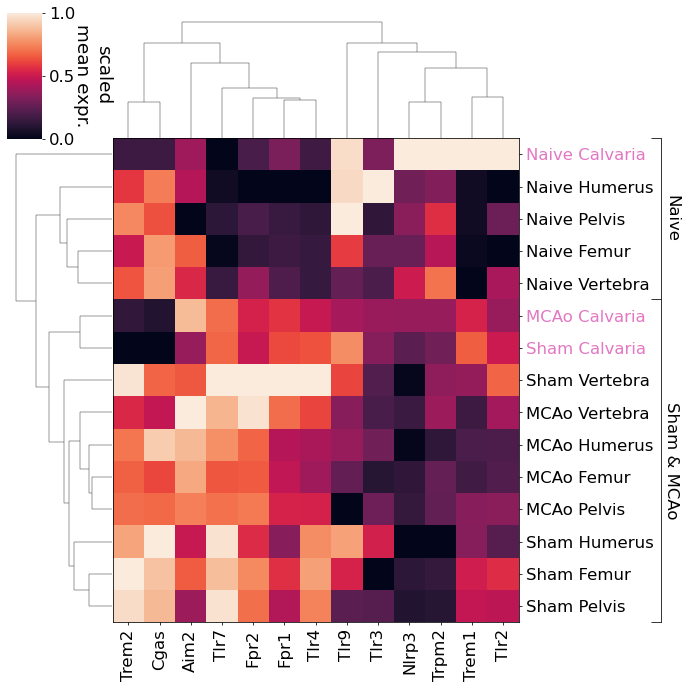

In [107]:
ax = sns.clustermap(df)#,cmap="inferno")
ax.ax_cbar.get_yaxis().labelpad = 38
ax.ax_cbar.set_ylabel('scaled\nmean expr.', rotation=270)
for label in ax.ax_heatmap.get_yticklabels():
    if "Calvaria" in label._text:
        label.set_color(region_to_color["Calvaria"])

ax.ax_heatmap.set_ylabel("")


# Second Y-axis
ax2 = ax.ax_heatmap.twinx()

ax2.spines["right"].set_position(("axes", 1.35))
ax2.tick_params('both', length=0, width=0, which='minor')
ax2.tick_params('both', length=10, direction='in', which='major')
ax2.yaxis.set_ticks_position("right")
ax2.yaxis.set_label_position("right")

ct_counts = {"Naive":5, "Sham & MCAo": 10}
n_ct_labels = ct_counts["Naive"] + ct_counts["Sham & MCAo"]
yticks = [1.0]
for _,count in ct_counts.items():
    yticks.append(yticks[-1] - count/n_ct_labels)
ticklabel_pos = [(yticks[i]+yticks[i+1])/2 for i in range(len(yticks)-1)]

ax2.set_yticks(yticks)#[0.0, 0.6, 1.0])
ax2.yaxis.set_major_formatter(ticker.NullFormatter())
ax2.yaxis.set_minor_locator(ticker.FixedLocator(ticklabel_pos))#[0.3, 0.8]))
ax2.yaxis.set_minor_formatter(ticker.FixedFormatter([key for key in ct_counts]))
#ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, ha='center', va='center')
plt.setp(ax2.yaxis.get_minorticklabels(), rotation=270, va="center")
#print(ax2.get_yticklabels())
#ax2.tick_params(axis="y", which="both", rotation=90)#, ha='center')

#ax2.spines['left'].set_visible(False)
#ax2.spines['top'].set_visible(False)

ax.ax_heatmap.spines["right"].set_visible(True)
ax.ax_heatmap.yaxis.set_ticks_position("right")
ax.ax_heatmap.yaxis.set_label_position("right")

plt.gcf().savefig("./figures/damps_heatmap.pdf", bbox_inches = "tight", transparent=True)

plt.show()

### Plot up down regulation wrt conditions

In [12]:
# Standard plot settings
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import matplotlib.ticker as ticker

plt.rcParams['figure.dpi'] = 70
plt.rcParams['savefig.dpi'] = 150
SMALL_SIZE = 17
MEDIUM_SIZE = 19
BIGGER_SIZE = 21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [13]:
gene_order = ["Trem2", "Cgas", "Aim2", "Tlr7", "Fpr2", "Tlr4", "Tlr9", "Tlr3", "Nlrp3", "Trpm2", "Trem1", "Tlr2"]

In [14]:
# Needs: pip install openpyxl
dfs = {}
for r in bones_no_scapula:
    for test in ['Naive vs Sham', 'Naive vs MCAo', 'Sham vs MCAo', 'Naive vs Injury']:
        dfs[f"{r} {test}"] = pd.read_excel(
            Path(RESULTS_DIR,"DAMPS_condition_tests_per_region.xlsx"), 
            sheet_name=f"{r} {test}",
            engine="openpyxl",
            index_col=0
        )
df = pd.concat([df for _,df in dfs.items()])

In [15]:
def get_group(lfc,sign):
    up_down = "up" if lfc > 0 else "down"
    significance = " (signif.)" if sign else ""
    return up_down+significance
    
df["group"] = df[["logfoldchanges","significant"]].apply(lambda x: get_group(x.logfoldchanges,x.significant), axis=1)

### plot version 0

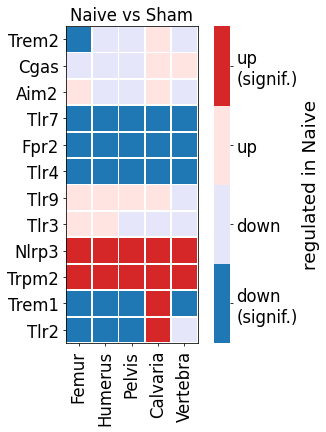

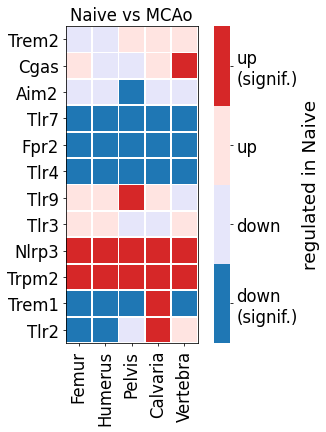

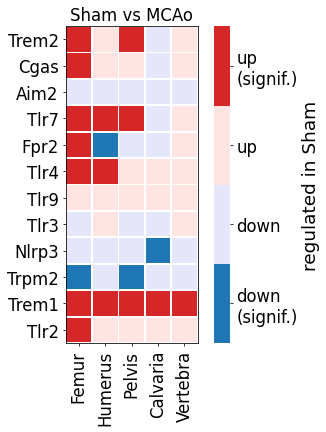

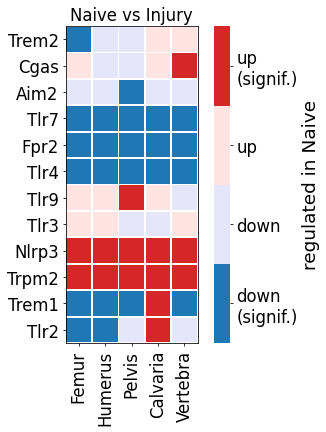

In [77]:
from matplotlib.colors import ListedColormap

for test in df["test"].unique():
    cond1 = test.split(" ")[0]
    cond2 = test.split(" ")[-1]
    
    # Get dataframe for heatmap
    df_ = pd.DataFrame(index=gene_order,columns=bones_no_scapula)
    for g in gene_order:
        for r in bones_no_scapula:
            df_.loc[g,r] = df.loc[(df["test"]==test) & (df["regions"]==r) & (df["names"]==g),"group"].values[0]
            
    ### Heatmap ###
    plt.figure(figsize=(6,6))
    
    value_to_int = {'down (signif.)':0, 'down':1, 'up':2,'up (signif.)':3}
    n = len(value_to_int)
    cmap = ListedColormap(["tab:blue", "lavender", "mistyrose", "tab:red"])
    
    ax = sns.heatmap(df_.replace(value_to_int), cmap=cmap, square=True, linewidths=0.8, linecolor='white')
    
    for key in ['left','right','top','bottom']:
        ax.spines[key].set_visible(True)
    ax.set_title(test)
        
    colorbar = ax.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
    colorbar.set_ticklabels(["\n".join(v.split(" ")) for v in list(value_to_int.keys())])  
    colorbar.ax.set_ylabel(f'regulated in {cond1}', rotation=90)

    plt.gcf().savefig(f"./figures/DAMPs_{cond1}_vs_{cond2}_significance_heatmap.png", bbox_inches = "tight", transparent=True)    
    
    plt.show()

### plot version 1

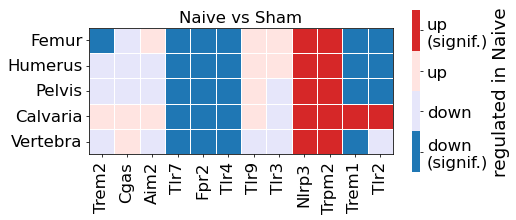

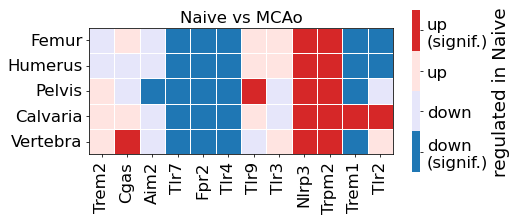

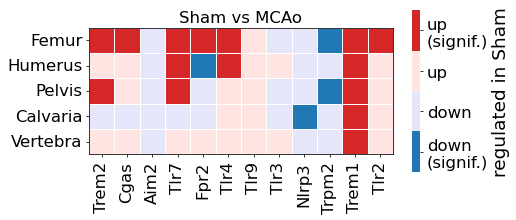

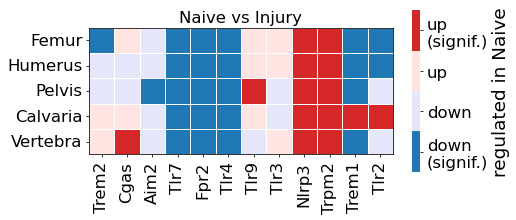

In [30]:
from matplotlib.colors import ListedColormap

for test in df["test"].unique():
    cond1 = test.split(" ")[0]
    cond2 = test.split(" ")[-1]
    
    # Get dataframe for heatmap
    df_ = pd.DataFrame(index=gene_order,columns=bones_no_scapula)
    for g in gene_order:
        for r in bones_no_scapula:
            df_.loc[g,r] = df.loc[(df["test"]==test) & (df["regions"]==r) & (df["names"]==g),"group"].values[0]
            
    ### Heatmap ###
    plt.figure(figsize=(7,3))
    
    value_to_int = {'down (signif.)':0, 'down':1, 'up':2,'up (signif.)':3}
    n = len(value_to_int)
    cmap = ListedColormap(["tab:blue", "lavender", "mistyrose", "tab:red"])
    
    ax = sns.heatmap(df_.replace(value_to_int).T, cmap=cmap, square=True, linewidths=0.8, linecolor='white')
    
    for key in ['left','right','top','bottom']:
        ax.spines[key].set_visible(True)
    ax.set_title(test)
        
    colorbar = ax.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
    colorbar.set_ticklabels(["\n".join(v.split(" ")) for v in list(value_to_int.keys())])  
    colorbar.ax.set_ylabel(f'regulated in {cond1}', rotation=90)

    plt.gcf().savefig(f"../figures/DAMPs_{cond1}_vs_{cond2}_significance_heatmap_v1.png", bbox_inches = "tight", transparent=True)    
    
    plt.show()

### plot version 2

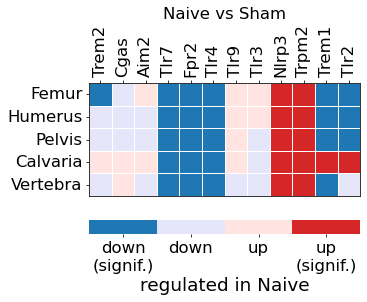

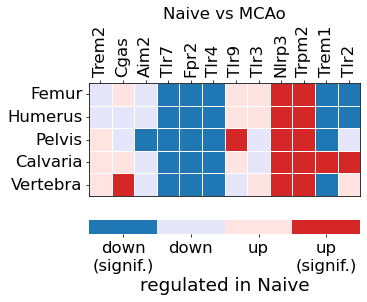

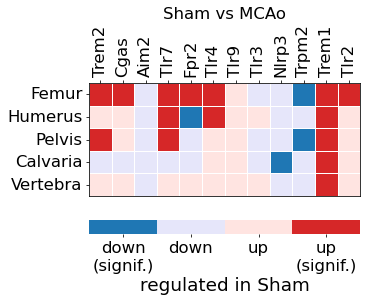

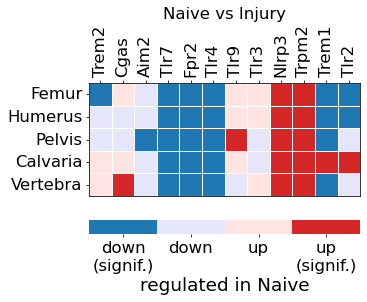

In [29]:
from matplotlib.colors import ListedColormap

for test in df["test"].unique():
    cond1 = test.split(" ")[0]
    cond2 = test.split(" ")[-1]
    
    # Get dataframe for heatmap
    df_ = pd.DataFrame(index=gene_order,columns=bones_no_scapula)
    for g in gene_order:
        for r in bones_no_scapula:
            df_.loc[g,r] = df.loc[(df["test"]==test) & (df["regions"]==r) & (df["names"]==g),"group"].values[0]
            
    ### Heatmap ###
    plt.figure(figsize=(5,3))
    
    value_to_int = {'down (signif.)':0, 'down':1, 'up':2,'up (signif.)':3}
    n = len(value_to_int)
    cmap = ListedColormap(["tab:blue", "lavender", "mistyrose", "tab:red"])
    
    ax = sns.heatmap(
        df_.replace(value_to_int).T, cmap=cmap, square=True, linewidths=0.8, linecolor='white',
        cbar_kws = dict(use_gridspec=False,location="bottom")
    )
    
    for key in ['left','right','top','bottom']:
        ax.spines[key].set_visible(True)
    ax.set_title(test)
        
    plt.tick_params(axis='both', which='major', #labelsize=10,
                    labelbottom=False, bottom=False, top=True, labeltop=True)
    plt.xticks(rotation=90)
        
    colorbar = ax.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
    colorbar.set_ticklabels(["\n".join(v.split(" ")) for v in list(value_to_int.keys())])  
    colorbar.ax.set_xlabel(f'regulated in {cond1}', rotation=0)

    plt.gcf().savefig(f"../figures/DAMPs_{cond1}_vs_{cond2}_significance_heatmap_v2.png", bbox_inches = "tight", transparent=True)    
    
    plt.show()